In [ ]:
!pip install --quiet scikit-learn pandas matplotlib seaborn scipy


# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# sklearn & scipy imports used across the notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
silhouette_score, davies_bouldin_score, calinski_harabasz_score,
adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, classification_report
)
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.optimize import linear_sum_assignment


warnings.filterwarnings('ignore')
RANDOM_STATE = 42 # for reproducibility


# Make plots look nicer
sns.set(style='whitegrid')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/human-activity-recognition-with-smartphones")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-activity-recognition-with-smartphones' dataset.
Path to dataset files: /kaggle/input/human-activity-recognition-with-smartphones


In [ ]:
import os

# List all files in the dataset folder
print(os.listdir(path))

['train.csv', 'test.csv']


In [ ]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'train.csv'))  # adjust name if needed
print(df.head())


   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

Shapes:  (7352, 561) (7352,) (7352,)


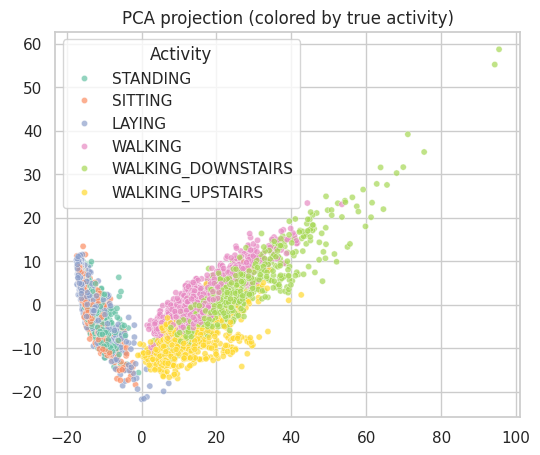

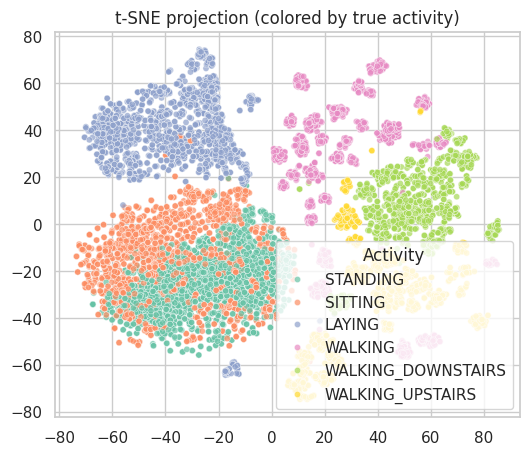

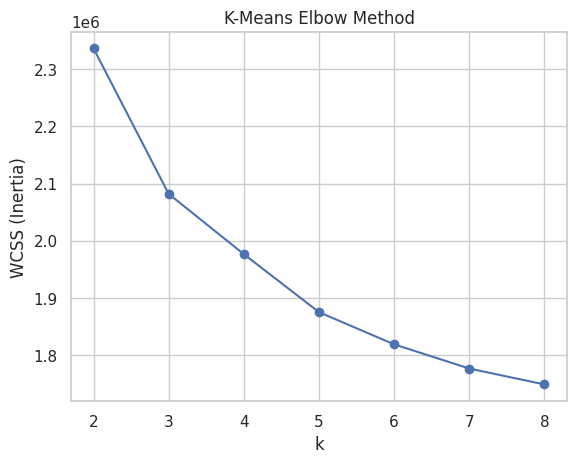

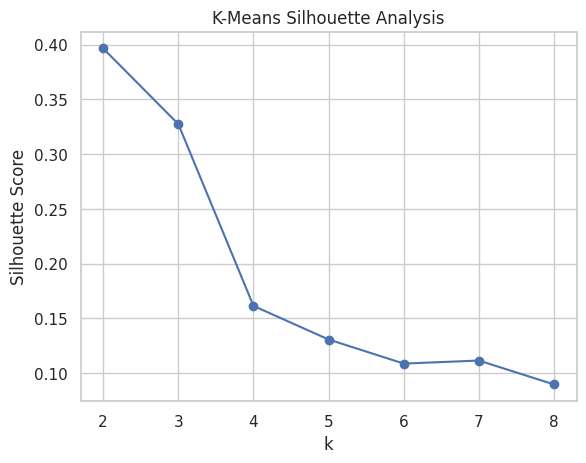

Best k chosen: 2


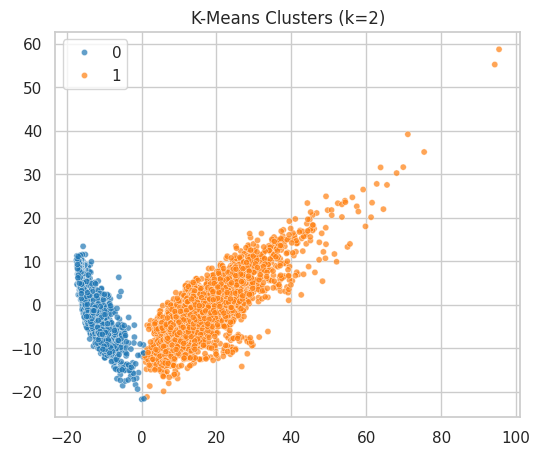

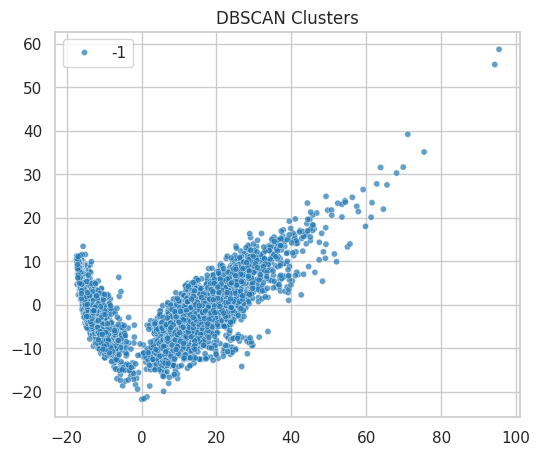

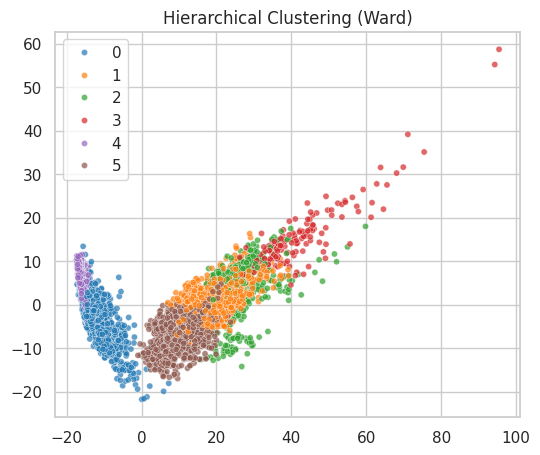

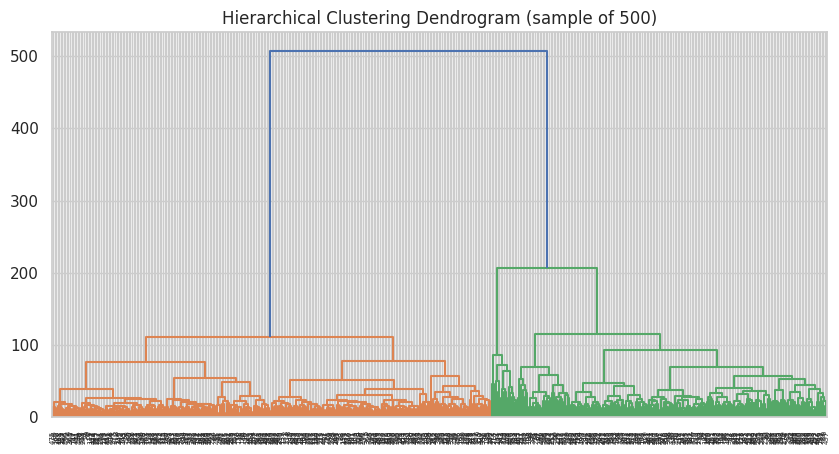


K-Means Results:
Silhouette: 0.3965
Davies-Bouldin: 1.0688
Calinski-Harabasz: 5626.0125
ARI: 0.3286
NMI: 0.5438

DBSCAN Results:
Silhouette: nan
Davies-Bouldin: nan
Calinski-Harabasz: nan
ARI: 0.0000
NMI: 0.0000

Hierarchical Results:
Silhouette: 0.0834
Davies-Bouldin: 2.7857
Calinski-Harabasz: 1730.8358
ARI: 0.2794
NMI: 0.4544


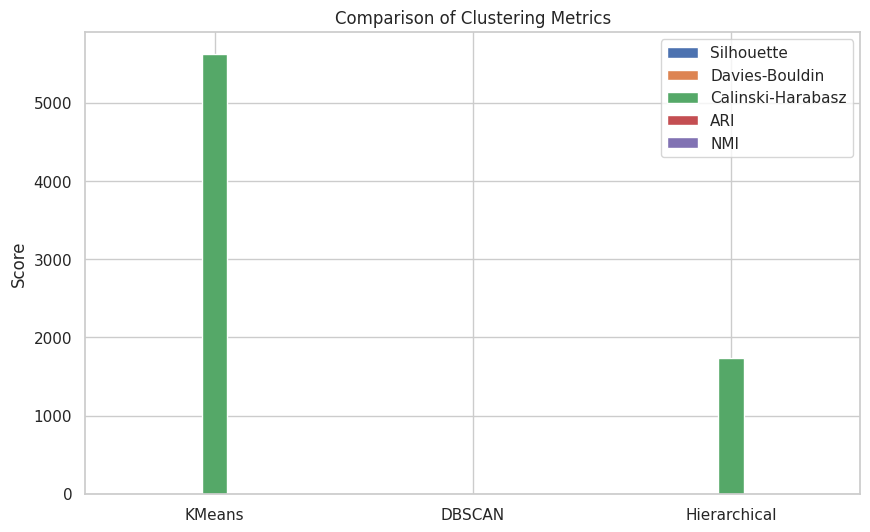

In [ ]:
# ================================
# Experiment 7 - Clustering HAR Data
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score, adjusted_rand_score,
                             normalized_mutual_info_score, confusion_matrix)

import scipy.cluster.hierarchy as sch

# ---------------------
# Step 1: Prepare Data
# ---------------------

# df is already loaded with columns:
# features + 'Activity' + 'subject'

# Separate features, labels, subjects
feature_cols = df.drop(columns=['Activity', 'subject']).columns
X = df[feature_cols]
y = df['Activity']
subjects = df['subject']

print("Shapes: ", X.shape, y.shape, subjects.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------
# Step 2: EDA & Dimensionality Reduction
# ---------------------

# PCA (keep 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set2", s=20, alpha=0.7)
plt.title("PCA projection (colored by true activity)")
plt.show()

# t-SNE for nonlinear projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="Set2", s=20, alpha=0.7)
plt.title("t-SNE projection (colored by true activity)")
plt.show()

# ---------------------
# Step 3: K-Means Clustering
# ---------------------

wcss = []
sil_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.plot(K_range, wcss, marker='o')
plt.xlabel("k")
plt.ylabel("WCSS (Inertia)")
plt.title("K-Means Elbow Method")
plt.show()

# Silhouette curve
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("K-Means Silhouette Analysis")
plt.show()

# Pick best k (highest silhouette)
best_k = K_range[np.argmax(sil_scores)]
print("Best k chosen:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=km_labels, palette="tab10", s=20, alpha=0.7)
plt.title(f"K-Means Clusters (k={best_k})")
plt.show()

# ---------------------
# Step 4: DBSCAN
# ---------------------

db = DBSCAN(eps=2, min_samples=10).fit(X_scaled)
db_labels = db.labels_

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_labels, palette="tab10", s=20, alpha=0.7)
plt.title("DBSCAN Clusters")
plt.show()

# ---------------------
# Step 5: Hierarchical Clustering
# ---------------------

hac = AgglomerativeClustering(n_clusters=6, linkage="ward")
hac_labels = hac.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=hac_labels, palette="tab10", s=20, alpha=0.7)
plt.title("Hierarchical Clustering (Ward)")
plt.show()

# Dendrogram (sample for speed)
plt.figure(figsize=(10,5))
sample_idx = np.random.choice(len(X_scaled), 500, replace=False)
sch.dendrogram(sch.linkage(X_scaled[sample_idx], method='ward'))
plt.title("Hierarchical Clustering Dendrogram (sample of 500)")
plt.show()

# ---------------------
# Step 6: Evaluation
# ---------------------

def evaluate(labels, algo_name):
    metrics = {}
    metrics['Silhouette'] = silhouette_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    metrics['Davies-Bouldin'] = davies_bouldin_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    metrics['Calinski-Harabasz'] = calinski_harabasz_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    metrics['ARI'] = adjusted_rand_score(y, labels)
    metrics['NMI'] = normalized_mutual_info_score(y, labels)
    print(f"\n{algo_name} Results:")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

results = {}
results['KMeans'] = evaluate(km_labels, "K-Means")
results['DBSCAN'] = evaluate(db_labels, "DBSCAN")
results['Hierarchical'] = evaluate(hac_labels, "Hierarchical")

# Bar plot for comparison
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(10,6))
plt.title("Comparison of Clustering Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


In [ ]:
!apt-get install pandoc -y

!jupyter nbconvert --to latex "/content/drive/MyDrive/Colab Notebooks/ML_Assignment7.ipynb"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ML_Assignment7.ipynb to latex
[NbConvertApp] Support files will be in ML_Assignment7_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/ML_Assignment7_files
[NbConvertApp] Writing 64881 bytes to /content/drive/MyDrive/Colab Notebooks/ML_Assignment7.tex


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab Notebooks/ML_Assignment7.tex')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>